# Customer Churn Prediction 
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. 

You can follow the steps below to guide your data analysis and model building portion of this project.

In [5]:
# import libraries

import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [7]:
# create a Spark session
spark = SparkSession \
.builder \
.appName('CustomerChurn') \
.getOrCreate()

In [8]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '192.168.0.32'),
 ('spark.driver.port', '64464'),
 ('spark.app.id', 'local-1594550919246'),
 ('spark.app.name', 'Cust'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [27]:
# Column types 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('registrationDate', 'timestamp'),
 ('tsDate', 'timestamp')]

In [26]:
# Obtain the number of distinct users in the smaller Sparkify dataset
# (In the full Sparkify dataset there is 22277 unique users)
df.select(['userId']).dropDuplicates().count()

226

In [37]:
# drop duplicates method would identify inconsistent number of unique users.
df.select(['firstName','gender','lastName','location','registration','userAgent','userId']) \
.where(df.userId != "") \
.dropDuplicates().count()

225

In [40]:
# Number of sessions
df.select("sessionId").dropDuplicates().count()

2354

In [63]:
# There are also no empty strings in the column
df.where(df.sessionId == "").count()

0

In [64]:
#SessionId is a unique identifier only for a specific user. Multiple users can have sessions labelled with the
#same sessionId
df.where(df.userId != "")\
.select(['userId','sessionId']).dropDuplicates()\
.groupby('sessionId').count().sort('count', ascending = False).show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|      167|    4|
|       54|    4|
|      112|    4|
|      202|    4|
|       65|    4|
+---------+-----+
only showing top 5 rows



In [65]:
# Sessions in the dataset can be very long. The longest lasted 267305 seconds which is more than 74 hours.
session_end = df.where(df.userId != "") \
.groupby(['userId','sessionId']).agg(Fmax('ts').alias('max'), 
                                     Fmin('ts').alias('min'), 
                                     ((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
.sort('sessionlength', ascending = False).show(5)

+------+---------+-------------+-------------+-------------+
|userId|sessionId|          max|          min|sessionlength|
+------+---------+-------------+-------------+-------------+
|    91|     1840|1542852334000|1542585029000|     267305.0|
|   115|      316|1538924417000|1538701498000|     222919.0|
|   101|      635|1539263366000|1539065365000|     198001.0|
|   120|      731|1539793336000|1539630700000|     162636.0|
|    61|      529|1539247693000|1539096212000|     151481.0|
+------+---------+-------------+-------------+-------------+
only showing top 5 rows



In [66]:
# Based on the analysis performed it seems that the maximum time between two consecutive logs that still belong to 
# the same sesssion is one hour. In the provided dataset the maximum interval is 3310 seconds which is around 55 minutes.
windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
df = df.withColumn("diff", (df.ts - df.previousts)/1000)
df.where(df.userId != "").agg(Fmax(col('diff'))).show()

+---------+
|max(diff)|
+---------+
|   3310.0|
+---------+



In [67]:
# Number of different artists
df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()

17655

In [38]:
# There are rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

8346

In [55]:
# The subscription 'level' variable is rather indepdendent of other variables in the dataset. The users can switch between 
# free and paid tier anytime and is not static. 
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [12]:
# Shape of the smaller Sparkify dataframe
nrows = df.count()
ncols = len(df.dtypes)
print(f'The imported dataframe has {nrows} rows and {ncols} columns.')

The imported dataframe has 286500 rows and 18 columns.


In [68]:
# Print first 5 rows to get the idea of the dataframe; first 11 columns in alphabetical order
df.select(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName','length', 'level', 'location', 'method', 'page']).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|
+----------------+------

In [19]:
# Print first 5 rows to get the idea of the dataframe; 12.-18. column
df.select(['registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']).show(5)

+-------------+---------+--------------------+------+-------------+--------------------+------+
| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+--------------------+------+-------------+--------------------+------+
|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [62]:
# Explore missing values in the 'userId' column
df.where(df.userId.isNull()).count()

0

In [20]:
# Logs belonging to a specific user
df.where(df.userId == 4).select(['userId','sessionId','itemInSession','auth','level','page','ts']).show(500)

+------+---------+-------------+---------+-----+---------------+-------------+
|userId|sessionId|itemInSession|     auth|level|           page|           ts|
+------+---------+-------------+---------+-----+---------------+-------------+
|     4|      240|            0|Logged In| free|       NextSong|1538356650000|
|     4|      240|            1|Logged In| free|         Logout|1538356651000|
|     4|      240|            4|Logged In| free|           Home|1538356686000|
|     4|      240|            5|Logged In| free|       NextSong|1538356889000|
|     4|      240|            6|Logged In| free|           Home|1538356954000|
|     4|      240|            7|Logged In| free|       NextSong|1538357110000|
|     4|      240|            8|Logged In| free|       NextSong|1538357328000|
|     4|      240|            9|Logged In| free|       NextSong|1538357543000|
|     4|      240|           10|Logged In| free|       NextSong|1538357746000|
|     4|      240|           11|Logged In| free|    

In [34]:
# Rows with empty string in the 'userId' column correspond to logs in which user has not been logged in
# (either 'Logged Out' or 'Guest' authentication levels). 
df.select(['userId','firstName','gender','lastName',
           'sessionId','location','auth','level','ts','page']).where(df.userId == "").show(10)

df.where(df.userId == "").groupby('auth').count().show()

+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|userId|firstName|gender|lastName|sessionId|location|      auth|level|           ts| page|
+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355745000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355807000| Help|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355841000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355842000|Login|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356678000| Home|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356679000|Login|
|      |     null|  null|    null|      100|    null|Logged Out| free|1538358102000|Login|
|      |     null|  null|    null|      241|    null|Logged Out| free|1538360117000|Login|

In [60]:
# Explore the auth column
df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [61]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column
df.where(df.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

+------+-------------------+---------+---------+--------------------+
|userId|             tsDate|sessionId|     auth|                page|
+------+-------------------+---------+---------+--------------------+
|    18|2018-10-07 22:26:30|      514|Cancelled|Cancellation Conf...|
|    32|2018-10-08 23:10:46|      540|Cancelled|Cancellation Conf...|
|   125|2018-10-12 06:35:18|      174|Cancelled|Cancellation Conf...|
|   105|2018-10-12 22:17:21|      508|Cancelled|Cancellation Conf...|
|    17|2018-10-13 23:19:44|      797|Cancelled|Cancellation Conf...|
+------+-------------------+---------+---------+--------------------+
only showing top 5 rows



In [41]:
#App users dataset
gender_dist = df.select(['userId','gender']).where(df.userId != "").dropDuplicates(['userId']).groupby('gender').count().toPandas()
gender_dist_rel = (gender_dist.set_index('gender') / sum(gender_dist['count']))

#Activity dataset
gender_dist_logs = df.where(df.userId != "").groupby('gender').count().toPandas()
gender_dist_logs_rel = (gender_dist_logs.set_index('gender') / sum(gender_dist_logs['count']))

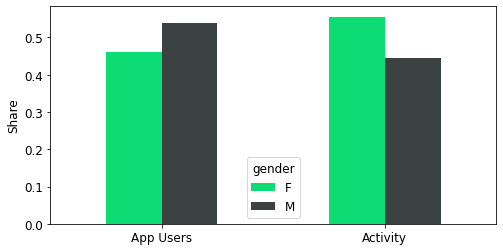

In [54]:
comparison = gender_dist_rel.merge(gender_dist_logs_rel, on='gender')
comparison.columns = ['App Users', 'Activity']

# Define plotting parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 12})

# Define colors to use throughout this notebook
colors = ["tealish green", "charcoal grey"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]

# Plot
comparison.transpose().plot.bar(rot = 0, color = [color1, color2]);
plt.ylabel('Share');

In [56]:
# Explore the 'page' column that represents the types of interactions with the music streaming service
# Obtain the distribution of the interaction types in the analyzed dataset
df.groupby('page').count().sort('count', ascending = False).show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|Cancellation Conf...|    52|
|              Cancel|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



In [57]:
# The smaller dataset is representative - distribution of the interaction types is similar in the full Sparkify dataset
page_pd_full = pd.DataFrame({'page' : ['NextSong','Home','Thumbs Up', 'Add to Playlist', 'Roll Advert', 'Add Friend', 
                                       'Login','Logout', 'Thumbs Down', 'Downgrade', 'Help', 'Settings', 'About', 
                                       'Upgrade', 'Save Settings', 'Error', 'Submit Upgrade', 'Submit Downgrade', 'Cancel',
                                     'Cancellation Confirmation', 'Register', 'Submit Registration'],
                             'count' : [20850272, 1343102, 1151465, 597921, 385212, 381664, 296350, 296005, 239212,
                                    184240, 155100, 147074, 92759, 50507, 29516, 25962, 15135, 6494, 5003, 5003, 802,401]})

page_pd_full['Full Sparkify Dataset'] = page_pd_full['count'] / sum(page_pd_full['count'])

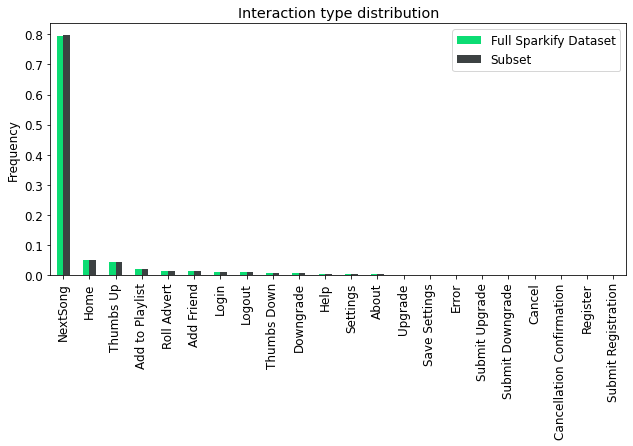

In [58]:
# Visualize the categorical distribution
page_pd = df.groupby('page').count().sort('count', ascending = False).toPandas()
page_pd['Subset'] = page_pd['count'] / sum(page_pd['count'])
# Compare to statistics calculated on gull Sparkify dataset
compare_pd = page_pd_full.merge(page_pd, on = 'page')

# Plot
plt.rcParams['figure.figsize'] = (10,7)
compare_pd.plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",  color = [color1, color2]);
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype1');

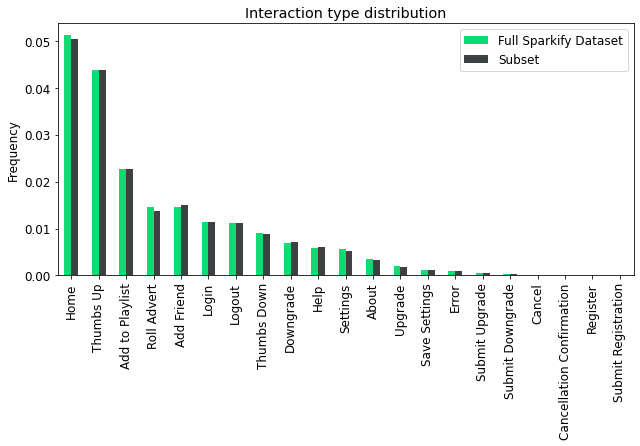

In [59]:
# Distribution ex playing songs
compare_pd[compare_pd['page']!='NextSong'].plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",
                                               color = [color1, color2]);

# Plot
plt.rcParams['figure.figsize'] = (10,7)
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype2')

# 3. Data transformation and Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [89]:
# Convert the timestamps in columns 'registration' and 'ts' into datetime format and add them to the dataframe
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [90]:
# Based on the data shown below it seems the observation period started at 02:01:57, October 1, 2018
df.select('userId', 'page', 'ts', 'tsDate').sort('ts').show(5)

+------+--------+-------------+-------------------+
|userId|    page|           ts|             tsDate|
+------+--------+-------------+-------------------+
|    30|NextSong|1538352117000|2018-10-01 02:01:57|
|     9|NextSong|1538352180000|2018-10-01 02:03:00|
|    30|NextSong|1538352394000|2018-10-01 02:06:34|
|     9|NextSong|1538352416000|2018-10-01 02:06:56|
|    30|NextSong|1538352676000|2018-10-01 02:11:16|
+------+--------+-------------+-------------------+
only showing top 5 rows



In [91]:
# Based on the data shown below it seems the observation period ended at 00:58:40, December 01, 2018 
df.select('userId', 'page', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

+------+---------------+-------------+-------------------+
|userId|           page|           ts|             tsDate|
+------+---------------+-------------+-------------------+
|300011|          About|1543622398000|2018-12-01 00:59:58|
|200008|       NextSong|1543622395000|2018-12-01 00:59:55|
|   138|       NextSong|1543622365000|2018-12-01 00:59:25|
|    39|       NextSong|1543622355000|2018-12-01 00:59:15|
|    30|Add to Playlist|1543622320000|2018-12-01 00:58:40|
|    30|       NextSong|1543622287000|2018-12-01 00:58:07|
|    56|       NextSong|1543622282000|2018-12-01 00:58:02|
|300011|           Home|1543622248000|2018-12-01 00:57:28|
|      |          Login|1543622241000|2018-12-01 00:57:21|
|      |           Home|1543622240000|2018-12-01 00:57:20|
+------+---------------+-------------+-------------------+
only showing top 10 rows



In [92]:
# Remove rows with missing userId 
df = df.where(df.userId != "")
df.count()

278150

## 3.1 Transformations on the Original Dataset

In [69]:
# Default observation start and end timestamps for users who have registered before October 1 and haven't churned
obs_start_default = 1538352000000
obs_end_default = 1543622400000

#### Registration
User's registration dates are listed in the registration column of the imported dataset, but we have observed that they do not always seem to be correct. For users who registered after the start of the default observation period the registration dates are not consistent with the actual log timestamps and activity types. We thus had to obtain late registrations by finding 'Submit Registration' logs in the page column. 

In [71]:
# "Submit registration" events have empty strings in the userId column.
# The userId can be inferred from the sessionId information.
df.select(['userId','auth','page','tsDate','sessionId']).where(df.page == 'Submit Registration').show()

+------+-----+-------------------+-------------------+---------+
|userId| auth|               page|             tsDate|sessionId|
+------+-----+-------------------+-------------------+---------+
|      |Guest|Submit Registration|2018-10-30 07:59:07|     1402|
|      |Guest|Submit Registration|2018-11-02 16:13:19|     1506|
|      |Guest|Submit Registration|2018-11-02 16:55:56|      154|
|      |Guest|Submit Registration|2018-11-08 22:10:33|     1719|
|      |Guest|Submit Registration|2018-11-27 00:12:49|     2288|
+------+-----+-------------------+-------------------+---------+



In [72]:
# Registration of the userId=154 - note that the time of "Submit Registration" log does not match the 
# registration time printed above.
df.select(['userId','auth','page','tsDate', 'sessionId']).where(df.sessionId == 1506).show(10)

+------+---------+-------------------+-------------------+---------+
|userId|     auth|               page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|      |    Guest|               Home|2018-11-02 16:12:56|     1506|
|      |    Guest|           Register|2018-11-02 16:13:18|     1506|
|      |    Guest|Submit Registration|2018-11-02 16:13:19|     1506|
|   154|Logged In|               Home|2018-11-02 16:15:35|     1506|
|   154|Logged In|           NextSong|2018-11-02 16:15:38|     1506|
|   154|Logged In|           NextSong|2018-11-02 16:18:39|     1506|
|   154|Logged In|           NextSong|2018-11-02 16:22:19|     1506|
|   154|Logged In|           NextSong|2018-11-02 16:26:59|     1506|
|   154|Logged In|           NextSong|2018-11-02 16:32:26|     1506|
|   154|Logged In|        Roll Advert|2018-11-02 16:33:03|     1506|
+------+---------+-------------------+-------------------+---------+
only showing top 10 rows



As can be seen in the table above, the 'Submit Registration' event is followed by user's first interaction in the same session. To identify users with late registrations we have shifted the page column by one index (within a given session) and checked whether the first entry of the lagged column reads 'Submit Registration'. For each such user the start of the observation period has been set to the timestamp of his/her first log, whereas for all other users the default start time applies.

In [73]:
# Lag the page column
windowsession = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn("lagged_page", lag(df.page).over(windowsession))

In [74]:
# With the lagged page column we can identify the users that registered later
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate', 'sessionId']).show()

+------+---------+-------------------+-------------------+---------+
|userId|     auth|        lagged_page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|   156|Logged In|Submit Registration|2018-11-27 00:14:00|     2288|
|   154|Logged In|Submit Registration|2018-11-02 16:15:35|     1506|
|   152|Logged In|Submit Registration|2018-10-30 07:59:09|     1402|
|   155|Logged In|Submit Registration|2018-11-02 16:56:25|      154|
|   153|Logged In|Submit Registration|2018-11-08 22:11:10|     1719|
+------+---------+-------------------+-------------------+---------+



In [75]:
# All the values calculated here are the same for all logs belonging to a given user. Nevertheless, we attach them to the
# original dataset, as they are needed for activity trend calculation 
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Identify users that registered after the start of observation, and infer the start date accordingly
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", 
                   when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

#### Cancellation
Similar to above, there are users who cancelled their service before the end of the default observation period, the so-called churned users. One can simply identify them by finding all the 'Cancellation Confirmation' entries in the page column. For each such user the end of the respective observation period has been set to the timestamp of his/her last log entry, whereas for all other users the default end date applies.

In [79]:
# Identify users that cancelled their service, i.e. users whose last log event is "Cancellation Confirmation", and
# obtain the corresponding end of the observation period. This is done on the original dataset
# so a single value, e.g. end of observation period, is copied to all rows belonging to a given userId.

df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))


#### Relative timing of each log
As mentioned before, we wanted to include activity trend as one of the predictors of churned users. Trend can be estimated by calculating a specific metric on the first and last k days of the observation period and then comparing them. 

In [80]:
# For each log compute the time from the beginning of observation...
df = df.withColumn("timefromstart", col('ts')-col("obsstart"))
# ...and time before the end of observation
df = df.withColumn("timebeforeend", col('obsend')-col('ts'))

In [81]:
# Example of a user with default observation start and earlier observation end due to Cancellation Confirmation
df.select(['userId','obsstart','obsend','endstate','page','ts','timefromstart','timebeforeend'])\
.where(df.userId == 100023).show(5)

+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|            endstate|      page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|100023|1538352000000|1539475237000|Cancellation Conf...|     About|1538665362000|    313362000|    809875000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538665432000|    313432000|    809805000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665433000|    313433000|    809804000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665434000|    313434000|    809803000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538767734000|    415734000|    707503000|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
o

#### Last Subscription Level
One other operation that we have performed on the original dataset is finding the user's last subscription level (free or paid) at the last log entry, so either user's subscription level at the time of cancellation, or at the end of the default observation period. 

In [82]:
# Obtain user's last subscription level and add it to the original dataset
df = df.withColumn("lastlevel", last(col('level')).over(windowuser))

In [83]:
# Remove rows with corrupted timestamps
df = df.where(df.ts < obs_end_default)
df.count()

286496

### Mapping and Aggregation
As the next step, we have transformed the original Sparkify dataset (one row per log) to a dataset with user-level information or statistics (one row per user), which have been obtained either through mapping from the original dataset (applies to user-level features such as user's gender, last subscription level, etc.) or aggregation (grouping the logs by userId, e.g. total activity count of each user).

The newly created dataset includes the following columns:

userId
* lastlevel : user's last subscription level, transformed into binary format (1 - paid tier, 0 - free tier)
* gender : gender, transformed into binary format (1 - female, 0 - male)
* obsstart, obsend: start and end of the observation period
* endstate : last interaction in the observation period
* nact : user's total number of interactions in the observation period
* nsongs, ntbup, ntbdown, nfriend, nplaylist, ndgrade, nupgrade, nhome, nadvert, nhelp, nsettings, nerror : number of songs played, thumbs up given, thumbs down given, friends added, songs added to playlist, downgrades, upgrades, home page visits, advertisements played, help page visits, settings visits, errors, respectively
* nact_recent, nact_oldest : user's activity in the last and first k days of the observation window, respectively
* nsongs_recent, nsongs_oldest : songs played in the last and first k days of the observation window, respectively

In [84]:
# Length of the estimation window for activity trend calculation
trend_est_days = 14
trend_est_hours = trend_est_days * 24
# In timestamp format
trend_est = trend_est_days * 24 * 60 * 60 * 1000

In [85]:
# Aggregation by userId
df_user = df.groupby('userId')\
.agg(
     # User-level features
     first(when(col('lastlevel') == 'paid', 1).otherwise(0)).alias('lastlevel'),
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     first(col('obsstart')).alias('obsstart'),
     first(col('obsend')).alias('obsend'),
     first(col('endstate')).alias('endstate'),
     
     # Aggregated activity statistics
     count(col('page')).alias('nact'),
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsongs"),
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("nsettings"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror"),
     
     # Aggregated activity statistics in different periods 
     Fsum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias("nact_recent"),
     Fsum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias("nact_oldest"),
     Fsum(when((col('page') == "NextSong") & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias("nsongs_recent"),
     Fsum(when((col('page') == "NextSong") & (col('timefromstart') < trend_est), 1).otherwise(0)).alias("nsongs_oldest") )

In [86]:
# Sample rows in a newly created dataset; user-level features
df_user.select(['userId','gender','lastlevel','obsstart','obsend','endstate']).show(5)

+------+------+---------+-------------+-------------+--------------------+
|userId|gender|lastlevel|     obsstart|       obsend|            endstate|
+------+------+---------+-------------+-------------+--------------------+
|100010|     1|        0|1538352000000|1543622400000|              Logout|
|200002|     0|        1|1538352000000|1543622400000|           Thumbs Up|
|   125|     0|        0|1538352000000|1539318918000|Cancellation Conf...|
|   124|     1|        1|1538352000000|1543622400000|                Home|
|    51|     0|        1|1538352000000|1539761972000|Cancellation Conf...|
+------+------+---------+-------------+-------------+--------------------+
only showing top 5 rows



In [87]:
# Sample rows in a newly created dataset; aggregated activity statistics
df_user.select(['userId','nact','nsongs','ntbup','ntbdown','nfriend','nplaylist',
                'ndgrade','nugrade','nhome','nadvert','nhelp','nsettings','nerror']).show(5)

+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|userId|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nsettings|nerror|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|100010| 381|   275|   17|      5|      4|        7|      0|      0|   11|     52|    2|        0|     0|
|200002| 474|   387|   21|      6|      4|        8|      0|      1|   20|      7|    2|        3|     0|
|   125|  11|     8|    0|      0|      0|        0|      0|      0|    0|      1|    0|        0|     0|
|    51|2464|  2111|  100|     21|     28|       52|      0|      0|   75|      0|   12|       12|     1|
|   124|4825|  4079|  171|     41|     74|      118|      0|      0|  176|      4|   23|       20|     6|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
only showing top 5 rows



In [88]:
# Sample rows in a newly created dataset; aggregated activity statistics in different periods
df_user.select(['userId','nact_recent','nact_oldest','nsongs_recent','nsongs_oldest']).show(5)

+------+-----------+-----------+-------------+-------------+
|userId|nact_recent|nact_oldest|nsongs_recent|nsongs_oldest|
+------+-----------+-----------+-------------+-------------+
|100010|         33|         40|           24|           31|
|200002|          0|         37|            0|           24|
|   125|         11|         11|            8|            8|
|   124|        509|       1093|          440|          921|
|    51|       1865|       2052|         1614|         1757|
+------+-----------+-----------+-------------+-------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.